# Using CharRNN Model and Vocab to train SMILES Generation Model

In [1]:
# change to the directory of the working file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# import the necessary modules
from datasets.data_loader import *
from utils.utils import *
from models.RNN import *
from utils.metrics import *
from utils.plot_figures import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# load the data
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

the vocab size is : 45


In [6]:
charlen = len(vocab)
print('the total num of charset is :', charlen)

cudnn.benchmark = True
lr = 4e-6
batch_size = 512
epoch = 30

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

the total num of charset is : 45


In [7]:
# create the dataset and dataloader
train_dataset = Seq2seqDataset(train_zeo, train_syn, train_smiles, vocab)
test_dataset = Seq2seqDataset(test_zeo, test_syn, test_smiles, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the model
model = RNNModel(input_size=charlen, 
                 synthesis_dim=24, 
                 embedding_dim=128,
                 hidden_size=256,
                 num_layers=3,
                 dropout=0,
                 vocab_size=charlen).to(device)

# define the loss function and the optimizer
loss_func = nn.CrossEntropyLoss(ignore_index=PAD) # ignore the padding index
optim = optim.Adam(model.parameters(), lr=lr)

total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))  # print the total parameters

total parameters: 0.39M


In [8]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        output, _ = model(synthesis_condition, tgt_input)
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        
        # calculate the accuracy
        pred = torch.argmax(output, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # backward
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num

In [9]:

def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            # forward
            output, _ = model(synthesis_condition, tgt_input)
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            # calculate the accuracy
            pred = torch.argmax(output, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            total_loss += loss.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train loss: %.4f, train acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d test loss: %.4f, test acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_charnn_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_charnn_model.pth')

100%|██████████| 284/284 [00:17<00:00, 16.43it/s]


epoch: 0, train loss: 3.3408, train acc: 0.3143


100%|██████████| 68/68 [00:03<00:00, 19.99it/s]


epoch: 0 test loss: 2.8084, test acc: 0.3544


100%|██████████| 284/284 [00:17<00:00, 16.43it/s]


epoch: 1, train loss: 2.5510, train acc: 0.3685


100%|██████████| 68/68 [00:03<00:00, 19.97it/s]


epoch: 1 test loss: 2.3831, test acc: 0.3787


100%|██████████| 284/284 [00:17<00:00, 16.44it/s]


epoch: 2, train loss: 2.2801, train acc: 0.3789


100%|██████████| 68/68 [00:03<00:00, 19.82it/s]


epoch: 2 test loss: 2.1820, test acc: 0.3886


100%|██████████| 284/284 [00:17<00:00, 16.42it/s]


epoch: 3, train loss: 2.0885, train acc: 0.4249


100%|██████████| 68/68 [00:03<00:00, 19.87it/s]


epoch: 3 test loss: 1.9982, test acc: 0.4530


100%|██████████| 284/284 [00:17<00:00, 16.46it/s]


epoch: 4, train loss: 1.9142, train acc: 0.4817


100%|██████████| 68/68 [00:03<00:00, 19.77it/s]


epoch: 4 test loss: 1.8407, test acc: 0.4940


100%|██████████| 284/284 [00:17<00:00, 16.50it/s]


epoch: 5, train loss: 1.7698, train acc: 0.5109


100%|██████████| 68/68 [00:03<00:00, 19.94it/s]


epoch: 5 test loss: 1.7113, test acc: 0.5232


100%|██████████| 284/284 [00:17<00:00, 16.44it/s]


epoch: 6, train loss: 1.6527, train acc: 0.5437


100%|██████████| 68/68 [00:03<00:00, 19.92it/s]


epoch: 6 test loss: 1.6084, test acc: 0.5764


100%|██████████| 284/284 [00:17<00:00, 16.44it/s]


epoch: 7, train loss: 1.5618, train acc: 0.5875


100%|██████████| 68/68 [00:03<00:00, 19.74it/s]


epoch: 7 test loss: 1.5286, test acc: 0.5908


100%|██████████| 284/284 [00:17<00:00, 16.45it/s]


epoch: 8, train loss: 1.4904, train acc: 0.5919


100%|██████████| 68/68 [00:03<00:00, 19.96it/s]


epoch: 8 test loss: 1.4654, test acc: 0.5928


100%|██████████| 284/284 [00:17<00:00, 16.45it/s]


epoch: 9, train loss: 1.4331, train acc: 0.5946


100%|██████████| 68/68 [00:03<00:00, 20.01it/s]


epoch: 9 test loss: 1.4135, test acc: 0.5959


100%|██████████| 284/284 [00:17<00:00, 16.51it/s]


epoch: 10, train loss: 1.3828, train acc: 0.5988


100%|██████████| 68/68 [00:03<00:00, 19.78it/s]


epoch: 10 test loss: 1.3668, test acc: 0.6004


100%|██████████| 284/284 [00:17<00:00, 16.45it/s]


epoch: 11, train loss: 1.3375, train acc: 0.6049


100%|██████████| 68/68 [00:03<00:00, 19.85it/s]


epoch: 11 test loss: 1.3230, test acc: 0.6080


100%|██████████| 284/284 [00:17<00:00, 16.33it/s]


epoch: 12, train loss: 1.2959, train acc: 0.6160


100%|██████████| 68/68 [00:03<00:00, 19.78it/s]


epoch: 12 test loss: 1.2832, test acc: 0.6217


100%|██████████| 284/284 [00:17<00:00, 16.39it/s]


epoch: 13, train loss: 1.2569, train acc: 0.6273


100%|██████████| 68/68 [00:03<00:00, 19.96it/s]


epoch: 13 test loss: 1.2468, test acc: 0.6303


100%|██████████| 284/284 [00:17<00:00, 16.47it/s]


epoch: 14, train loss: 1.2216, train acc: 0.6368


100%|██████████| 68/68 [00:03<00:00, 19.96it/s]


epoch: 14 test loss: 1.2135, test acc: 0.6393


100%|██████████| 284/284 [00:17<00:00, 16.43it/s]


epoch: 15, train loss: 1.1897, train acc: 0.6450


100%|██████████| 68/68 [00:03<00:00, 19.97it/s]


epoch: 15 test loss: 1.1820, test acc: 0.6468


100%|██████████| 284/284 [00:17<00:00, 16.49it/s]


epoch: 16, train loss: 1.1593, train acc: 0.6524


100%|██████████| 68/68 [00:03<00:00, 19.98it/s]


epoch: 16 test loss: 1.1536, test acc: 0.6536


100%|██████████| 284/284 [00:17<00:00, 16.44it/s]


epoch: 17, train loss: 1.1315, train acc: 0.6598


100%|██████████| 68/68 [00:03<00:00, 19.99it/s]


epoch: 17 test loss: 1.1266, test acc: 0.6612


100%|██████████| 284/284 [00:17<00:00, 16.47it/s]


epoch: 18, train loss: 1.1043, train acc: 0.6666


100%|██████████| 68/68 [00:03<00:00, 19.87it/s]


epoch: 18 test loss: 1.0994, test acc: 0.6671


100%|██████████| 284/284 [00:17<00:00, 16.42it/s]


epoch: 19, train loss: 1.0773, train acc: 0.6722


100%|██████████| 68/68 [00:03<00:00, 19.94it/s]


epoch: 19 test loss: 1.0735, test acc: 0.6729


100%|██████████| 284/284 [00:17<00:00, 16.46it/s]


epoch: 20, train loss: 1.0515, train acc: 0.6781


100%|██████████| 68/68 [00:03<00:00, 19.78it/s]


epoch: 20 test loss: 1.0499, test acc: 0.6786


100%|██████████| 284/284 [00:17<00:00, 16.51it/s]


epoch: 21, train loss: 1.0288, train acc: 0.6836


100%|██████████| 68/68 [00:03<00:00, 20.01it/s]


epoch: 21 test loss: 1.0289, test acc: 0.6829


100%|██████████| 284/284 [00:17<00:00, 16.48it/s]


epoch: 22, train loss: 1.0087, train acc: 0.6879


100%|██████████| 68/68 [00:03<00:00, 19.72it/s]


epoch: 22 test loss: 1.0093, test acc: 0.6869


100%|██████████| 284/284 [00:17<00:00, 16.42it/s]


epoch: 23, train loss: 0.9903, train acc: 0.6914


100%|██████████| 68/68 [00:03<00:00, 19.89it/s]


epoch: 23 test loss: 0.9927, test acc: 0.6901


100%|██████████| 284/284 [00:17<00:00, 16.45it/s]


epoch: 24, train loss: 0.9731, train acc: 0.6953


100%|██████████| 68/68 [00:03<00:00, 19.74it/s]


epoch: 24 test loss: 0.9766, test acc: 0.6940


100%|██████████| 284/284 [00:17<00:00, 16.42it/s]


epoch: 25, train loss: 0.9579, train acc: 0.6991


100%|██████████| 68/68 [00:03<00:00, 19.98it/s]


epoch: 25 test loss: 0.9622, test acc: 0.6973


100%|██████████| 284/284 [00:17<00:00, 16.45it/s]


epoch: 26, train loss: 0.9441, train acc: 0.7017


100%|██████████| 68/68 [00:03<00:00, 19.94it/s]


epoch: 26 test loss: 0.9483, test acc: 0.6998


100%|██████████| 284/284 [00:17<00:00, 16.43it/s]


epoch: 27, train loss: 0.9300, train acc: 0.7044


100%|██████████| 68/68 [00:03<00:00, 19.98it/s]


epoch: 27 test loss: 0.9360, test acc: 0.7023


100%|██████████| 284/284 [00:17<00:00, 16.49it/s]


epoch: 28, train loss: 0.9174, train acc: 0.7065


100%|██████████| 68/68 [00:03<00:00, 20.01it/s]


epoch: 28 test loss: 0.9242, test acc: 0.7048


100%|██████████| 284/284 [00:17<00:00, 16.47it/s]


epoch: 29, train loss: 0.9066, train acc: 0.7093


100%|██████████| 68/68 [00:03<00:00, 19.91it/s]

epoch: 29 test loss: 0.9133, test acc: 0.7078


In [11]:
def generate_rnn(model, start_sequence, condition_props, max_length, vocab, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (RNN): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits, _ = model(condition_props, generated_sequences)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token
        if all(next_token[i].item() == EOS for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [12]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_rnn(model, tgt[:, :10], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 68/68 [01:21<00:00,  1.20s/it]


In [13]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1[N+]2(CC)CCCCCC1CC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1C2C([N+](C)(C)CCCCCC[N+](C)(C)CCCCC1)C'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1CC[N+]2(C)CCCCCC2CCC[N+]1(C)CCCCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1CCCC2[N+](CC)(CC)CCCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C12C(CCCCCC[N+](C)(C)C)CCCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1CC[N+]2(C)CCCC1CCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1CC[N+]2(C)CC(C)CCC(C[N+]1(CCC)CCCC2)CCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: '[N+]12(CCCCCCCCCC[N+](C)(C)C)CCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C12CCCCC1CCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C12C(CCC[N+](C)(C)C)CCCCCCCC1'
[12:53:28] SMILES Parse Error: unclosed ring for input: 'C1CCCC[N+](CC)(CC)CCC'
[12:53:28] SMILES Parse Error:

Validity rate: 0.226
Uniqueness rate: 0.984
Novelty rate: 0.9857723577235772
Reconstructability rate: 0.014227642276422764
Novelty rate: 0.9857723577235772
IntDiv: 0.8063722592768382


[12:53:31] SMILES Parse Error: unclosed ring for input: 'C([n+]1c(C)c(C)c1C)ccc1'
[12:53:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 14 15
[12:53:31] SMILES Parse Error: unclosed ring for input: '[n+]1(Cc2cccc(C)c1)c1'
[12:53:31] SMILES Parse Error: unclosed ring for input: 'c1n(C)c(C)c1C(C)CC[N+]1(C)CCCCCCCCCCCCCC[n+]1cccc1'
[12:53:31] SMILES Parse Error: extra open parentheses for input: 'c1ccc(C[n+]1ccn(C)c1C'
[12:53:31] Can't kekulize mol.  Unkekulized atoms: 0 4 6
[12:53:31] SMILES Parse Error: extra open parentheses for input: 'Cn1c(C)[n+](CCCCCCCCC[N+]2(C)C'
[12:53:31] SMILES Parse Error: unclosed ring for input: 'c1[n+](Ccccc2)c1'
[12:53:31] SMILES Parse Error: extra close parentheses while parsing: Cc1n(C)cc1)CCCC1
[12:53:31] SMILES Parse Error: Failed parsing SMILES 'Cc1n(C)cc1)CCCC1' for input: 'Cc1n(C)cc1)CCCC1'
[12:53:31] Can't kekulize mol.  Unkekulized atoms: 0 9 11
[12:53:31] SMILES Parse Error: unclosed ring for input: 'c1cc(C[n+]1cccccc2)C1'
[12:53:31] SMILE

FCD score: 3.2351142654494964


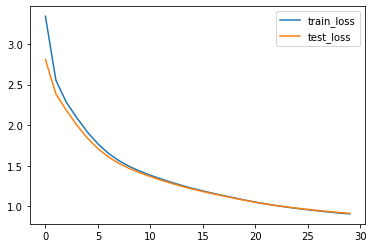

In [14]:
# plot the training and testing loss
plot_loss(train_loss_history, test_loss_history, 'Charnn')